In [256]:
from self_supervised.pipelines.representation_model import RepresentationModel, YoloEncoder

%reload_kedro
model_description = catalog.load("yolov5_l_description")
trained_model = catalog.load("trained_model", version="2023-02-10T00.00.00.000Z")
#encoder = YoloEncoder(model_description=model_description)
#trained_model = RepresentationModel(encoder=encoder)
trained_model = trained_model.eval()

2023-03-01 13:30:37,593 - kedro.ipython - INFO - Resolved project path as: /home/daniel/git/self-supervised-learning.
To set a different path, run '%reload_kedro <project_root>'
2023-03-01 13:30:37,595 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.8/site-packages/kedro/framework/startup.py:98: DeprecationWarning: project_version in pyproject.toml is deprecated, use kedro_init_version instead
  warnings.warn(

2023-03-01 13:30:37,734 - kedro.ipython - INFO - Kedro project Self-Supervised Learning
2023-03-01 13:30:37,735 - kedro.ipython - INFO - Defined global variable 'context', 'session', 'catalog' and 'pipelines'
2023-03-01 13:30:37,739 - kedro.io.data_catalog - INFO - Loading data from 'yolov5_l_description' (YAMLDataSet)...
2023-03-01 13:30:37,745 - kedro.io.data_catalog - INFO - Loading data from 'trained_model' (PytorchModelDataSet)...


2023-03-01 13:30:37.746 | WARNING  | self_supervised.extras.datasets.pytorch_model_data_set:_load:42 - CUDA not available, automatically mapping variables to the CPU.
2023-03-01 13:30:38.142 | INFO     | self_supervised.pipelines.train_simclr.nodes:<module>:35 - Using cpu device.


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /home/daniel/git/self-supervised-learning/.venv/lib/python3.8/site-packages/kedro/io/core.py:186 │
│ in load                                                                                          │
│                                                                                                  │
│   183 │   │   self._logger.debug("Loading %s", str(self))                                        │
│   184 │   │                                                                                      │
│   185 │   │   try:                                                                               │
│ ❱ 186 │   │   │   return self._load()                                                            │
│   187 │   │   except DataSetError:                                                               │
│   188 │   │   │   raise                                                                          │
│   189 │   │   except Exception as exc:                                                           │
│                                                                                                  │
│ /home/daniel/git/self-supervised-learning/src/self_supervised/extras/datasets/pytorch_model_data │
│ _set.py:48 in _load                                                                              │
│                                                                                                  │
│   45 │   │   │   )                                                                               │
│   46 │   │   │   load_args["map_location"] = torch.device("cpu")                                 │
│   47 │   │                                                                                       │
│ ❱ 48 │   │   return torch.load(self._get_load_path().as_posix(), **load_args)                    │
│   49 │                                                                                           │
│   50 │   def _save(self, model: nn.Module) -> None:                                              │
│   51 │   │   """                                                                                 │
│                                                                                                  │
│ /home/daniel/git/self-supervised-learning/.venv/lib/python3.8/site-packages/torch/serialization. │
│ py:789 in load                                                                                   │
│                                                                                                  │
│    786 │   │   │   │   │   │   return _load(opened_zipfile, map_location, _weights_only_unpickl  │
│    787 │   │   │   │   │   except RuntimeError as e:                                             │
│    788 │   │   │   │   │   │   raise pickle.UnpicklingError(UNSAFE_MESSAGE + str(e)) from None   │
│ ❱  789 │   │   │   │   return _load(opened_zipfile, map_location, pickle_module, **pickle_load_  │
│    790 │   │   if weights_only:                                                                  │
│    791 │   │   │   try:                                                                          │
│    792 │   │   │   │   return _legacy_load(opened_file, map_location, _weights_only_unpickler,   │
│                                                                                                  │
│ /home/daniel/git/self-supervised-learning/.venv/lib/python3.8/site-packages/torch/serialization. │
│ py:1131 in _load                                                                                 │
│                                                                                                  │
│   1128 │                                                                                         │
│   1129 │   unpickler = UnpicklerWrapper(data_file, **pickle_load_args)                           │
│   1130 │   unpickler.persistent_load = persistent_load     

In [243]:
from pathlib import Path

dataset_path = Path("/home/daniel/lab_share/projects/CottonFlower2021/flower_dataset")
image_dir = dataset_path / "flower01" / "images"

In [244]:
from torchvision.io import read_image
from torchvision.transforms.functional import resize
from tqdm import tqdm
import torch

image_reps = []

image_list = sorted(list(image_dir.iterdir()))
for image_path in tqdm(image_list):
    image = read_image(image_path.as_posix())
    image.requires_grad = False
    image = resize(image, (512, 512))
    image = image.to(torch.float) / 255
    image_ex = image[None, :, :, :]
    
    image_reps.append(trained_model(image_ex)[0].detach().numpy())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 458/458 [01:05<00:00,  7.04it/s]


In [245]:
# Load flower counts.
import pandas as pd

labels_dir = dataset_path / "flower01" / "labels"
all_labels = []
labels_list = sorted(list(labels_dir.iterdir()))
for labels_path in labels_list:
    frame_labels = pd.read_csv(labels_path, sep=" ", names=["class", "x", "y", "width", "height"])
    frame_labels["frame"] = labels_path.name
    all_labels.append(frame_labels)
    
all_labels = pd.concat(all_labels, ignore_index=True)
all_labels

,class,x,y,width,height,frame
0,0,0.635938,0.238889,0.020833,0.037037,000001.txt
1,0,0.379427,0.065278,0.015104,0.034259,000001.txt
2,0,0.634375,0.245370,0.020833,0.037037,000002.txt
3,0,0.379948,0.068981,0.015104,0.034259,000002.txt
4,0,0.379948,0.069907,0.015104,0.034259,000003.txt
...,...,...,...,...,...,...
1987,0,0.495833,0.971759,0.030208,0.052778,000383.txt
1988,0,0.496875,0.976852,0.030208,0.046296,000384.txt
1989,0,0.497656,0.980093,0.028646,0.037963,000385.txt
1990,0,0.497135,0.986111,0.028646,0.027778,000386.txt


In [246]:
import numpy as np

# Create flower counts labels.
flower_counts = []
for image_path in labels_list:
    flower_counts.append(np.count_nonzero(all_labels["frame"] == image_path.name))
    
# Any missing counts are zeros.
for _ in range(len(flower_counts), len(image_reps)):
    flower_counts.append(0)

In [247]:
test_image_dir = dataset_path / "flower02" / "images"

test_image_reps = []

image_list = sorted(list(test_image_dir.iterdir()))
for image_path in tqdm(image_list):
    image = read_image(image_path.as_posix())
    image.requires_grad = False
    image = resize(image, (512, 512))
    image = image.to(torch.float) / 255
    image_ex = image[None, :, :, :]
    
    test_image_reps.append(trained_model(image_ex)[0].detach().numpy())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 333/333 [00:49<00:00,  6.72it/s]


In [248]:
test_labels_dir = dataset_path / "flower02" / "labels"
all_labels_test = []
labels_list = sorted(list(test_labels_dir.iterdir()))
for labels_path in labels_list:
    frame_labels = pd.read_csv(labels_path, sep=" ", names=["class", "x", "y", "width", "height"])
    frame_labels["frame"] = labels_path.name
    all_labels_test.append(frame_labels)
    
all_labels_test = pd.concat(all_labels_test, ignore_index=True)
all_labels_test

,class,x,y,width,height,frame
0,0,0.407813,0.032870,0.014583,0.023148,000001.txt
1,0,0.408854,0.042130,0.014583,0.023148,000002.txt
2,0,0.408854,0.042130,0.014583,0.023148,000003.txt
3,0,0.408854,0.042130,0.014583,0.023148,000004.txt
4,0,0.408854,0.042130,0.014583,0.023148,000005.txt
...,...,...,...,...,...,...
1583,0,0.441406,0.814352,0.020313,0.036111,000287.txt
1584,0,0.437240,0.838426,0.020313,0.036111,000288.txt
1585,0,0.433073,0.858796,0.020313,0.036111,000289.txt
1586,0,0.434635,0.871759,0.011979,0.028704,000290.txt


In [249]:
# Create flower counts.
test_flower_counts = []
for image_path in labels_list:
    test_flower_counts.append(np.count_nonzero(all_labels_test["frame"] == image_path.name))
    
# Any missing counts are zeros.
for _ in range(len(test_flower_counts), len(test_image_reps)):
    test_flower_counts.append(0)

In [250]:
# Create combined dataset.
all_image_reps = image_reps + test_image_reps
all_flower_counts = flower_counts + test_flower_counts
train_indices = np.arange(len(image_reps))
test_indices = np.arange(len(image_reps), len(all_image_reps))

In [251]:
from sklearn.linear_model import RidgeCV

all_flower_counts = np.array(all_flower_counts, dtype=float)
all_image_reps_arr = np.concatenate(all_image_reps, axis=0)

alphas = [1e-6, 1e-4, 0.01, 0.1, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0]
reg = RidgeCV(alphas=alphas, cv=((train_indices, test_indices),)).fit(all_image_reps_arr, all_flower_counts)

2023-03-01 13:23:32,806 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.47212e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



In [252]:
test_image_reps_arr = np.concatenate(test_image_reps, axis=0)
test_preds = reg.predict(test_image_reps_arr)
test_preds

array([     1.4031,      1.7776,      1.5542,       1.236,      1.3145,      1.1864,      1.3139,        1.07,       1.361,       1.206,      1.4035,      1.2826,      1.5858,      1.4328,      1.8749,      1.8212,      1.8277,      2.2613,       2.639,      2.3552,      2.3836,      2.5988,      2.5168,      2.7472,
            2.5527,      2.9572,      2.9693,        2.79,      3.0361,      3.0809,       3.176,       2.891,      3.3787,      3.2892,       3.102,      3.3598,        3.71,      4.0218,      3.5392,      3.9043,      3.8211,      4.1761,      3.8649,      3.8635,      4.0533,      4.7452,      5.1644,      4.7031,
            4.1422,      4.2442,      4.1923,      4.7945,      4.8769,      5.3137,      4.9323,       4.965,      4.9803,      5.1974,      5.4355,      5.4069,      4.9439,      5.3522,      5.1407,      5.4364,      5.9078,      5.6243,      5.9002,      5.5735,      5.7324,       5.501,      5.8113,      5.9931,
            6.3096,      6.9907,      7.4143,      7.2505,      7.4701,      7.3142,      6.7635,       6.497,      6.5506,      6.6518,      6.7269,      7.2902,      7.8856,      7.9166,      7.9699,      7.5845,      7.6943,      7.5321,      7.1019,        7.47,       8.254,      8.6041,      8.5201,      7.8676,
            7.7289,      7.5325,       8.357,      7.7383,      7.5034,      7.4233,      7.2332,       7.359,      7.5847,      7.8052,      7.1237,      7.1759,      6.2946,      6.8306,      6.5572,      6.2042,       6.245,      6.2959,      6.2788,      5.9974,      6.0893,      5.5001,      5.6723,      5.8592,
            5.5063,      5.0874,      5.1906,      4.8466,      5.0904,      4.8489,      4.7878,      5.3497,      5.6097,      5.5744,      5.7904,      5.3447,      5.4667,      5.1194,      5.2984,      5.8627,      5.7161,       5.984,      6.2025,       6.581,      5.8246,       5.604,      5.8494,      5.7923,
            5.9622,      5.7523,      5.3172,      5.9571,      6.0834,      5.8676,      5.6695,      5.2031,      5.0594,       4.885,      4.9538,      5.8448,       5.566,      6.4798,      5.2913,      5.1306,      5.8951,      5.6078,      4.7034,      5.4194,      4.8572,      5.7288,      5.5442,      6.4236,
            5.3763,      5.9214,      5.3693,      5.9059,      5.8162,      5.4585,      5.7839,      6.2397,      6.1877,      6.0973,      6.6462,      6.2038,      5.9956,      5.4952,      5.9088,       6.189,      5.8704,      6.3355,      6.3539,      7.2292,      7.2295,      7.8797,      7.4933,      8.0153,
            7.8189,       8.077,      7.8289,      7.8579,      8.6627,      9.3313,      8.7614,      8.4424,      7.2994,       7.277,      7.7145,      7.7705,       7.377,      7.8394,      8.8456,       9.226,      8.6386,      8.4219,      8.3268,       7.435,      7.2615,      7.9288,      8.1108,      7.9655,
            8.5574,      8.6255,      8.7794,      7.9557,       8.118,      7.7499,      5.8402,      6.5337,      5.6022,      6.5544,      6.7295,      7.5751,      6.9245,       6.734,      6.1682,      5.7516,      5.7959,      5.5372,      6.5219,      6.9544,       7.162,       5.789,      5.4737,      4.7874,
            4.4524,      4.2397,       4.561,      5.1629,           5,      4.8926,      5.8253,      5.9552,      4.8954,      5.1265,      4.5608,      4.3056,      4.1137,      4.3352,      4.6969,      5.1698,      4.7301,      4.8345,      4.9024,      4.3967,      4.2589,      3.8119,      4.4235,      3.6433,
            4.6049,      4.0703,      4.5788,      3.9986,      5.2036,      4.7921,      3.9489,      3.4286,      3.1833,       3.964,      3.8066,      4.0109,      3.2136,      2.6042,      2.8805,      2.4104,      2.7512,      2.4595,      2.9194,      3.0152,      2.9053,      3.3367,      2.7838,      2.2842,
            1.6364,      1.7616,      1.7636,      1.9309,      2.2876,      2.2261,      2.4803,      2.2133,      2.4728,      1.8905,      1.4662,      1.4267,     0.822

In [253]:
errors = test_preds - test_flower_counts
np.mean(np.abs(errors))

0.803699055591503

2023-03-01 13:23:43,116 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.8/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":

2023-03-01 13:23:43,118 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.8/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)



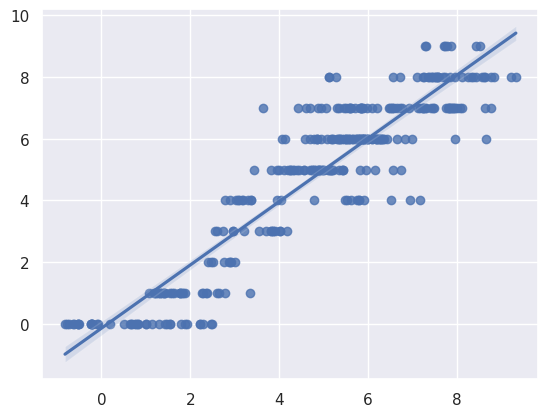

In [254]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

sns.regplot(x=test_preds, y=test_flower_counts)
plt.show()

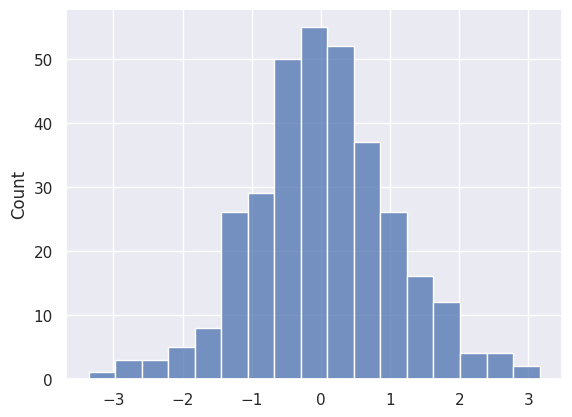

In [255]:
sns.histplot(x=errors)